## This notebook tries to generate the test dataset for the beamforming sync test.

In the first step, we should find which trace is suitable to use for test, we can plot some of them

In [48]:
import pyasdf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
from obspy import Stream
import pickle

In [11]:
data=pyasdf.ASDFDataSet("../bf_visualize/data/tongaml.h5",mode="r")

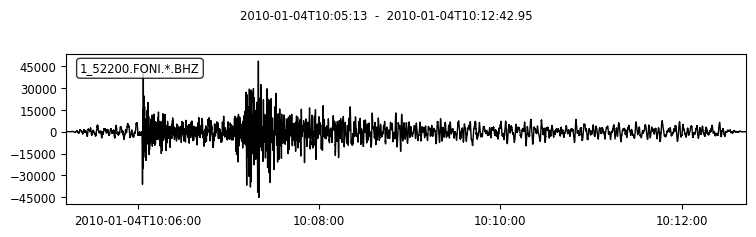

In [9]:
data.waveforms["1_52200.FONI"].raw_recording[2].plot();

For 1_52200 and FONI, we know the station and event location?

In [13]:
info=pd.read_csv("../bf_visualize/data/arrival_info_by_ziyi_20220921_add_sta_info.csv")

In [15]:
for i in range(len(info)):
    row=info.iloc[i]
    if row.EVENT_ID=="1_52200" and row.STATION=="FONI":
        print(row)
        break

Unnamed: 0                            5221
EVENT_ID                           1_52200
ORIGIN_TIME    2010-01-04T10:04:39.510002Z
STATION                               FONI
NETWORK                                 Z1
ELON                             -178.4858
ELAT                               -20.865
EDEP                              617.5494
PTIME                                83.49
STIME                           149.669998
PSTIME                           93.009453
PST_ERR                           0.851581
PS_FREQ                           4.934232
SLON                           -174.630798
SLAT                              -20.2796
SEVL                                  19.0
Name: 5221, dtype: object


From the paper, the distance between nearby events can be 50km apart. We can test for 50 km depth range. Just generate random 100 points in the range and try to shift the waveform

In [17]:
N=100
lons_offset=np.random.rand(N)*0.5-0.25
lats_offset=np.random.rand(N)*0.5-0.25
deps_offset=np.random.rand(N)*50-25

ref_lon=-178.4858
ref_lat=-20.865
ref_dep=617.5494

lons=lons_offset+ref_lon
lats=lats_offset+ref_lat
deps=deps_offset+ref_dep

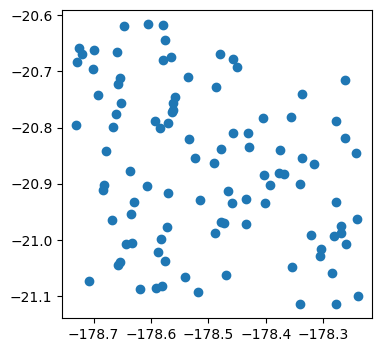

In [20]:
# plot in horizontal
plt.figure(figsize=(4,4))

plt.scatter(lons,lats)

plt.show()

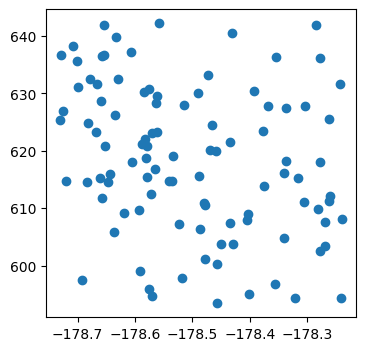

In [21]:
# plot vertically
plt.figure(figsize=(4,4))

plt.scatter(lons,deps)

plt.show()

Now we should calculate the travel time for all the traces

In [36]:
model = TauPyModel(model="iasp91")

ref_dist=locations2degrees(ref_lat,ref_lon,-20.2796,-174.630798)
print(ref_dist)
ref_t=model.get_travel_times(source_depth_in_km=ref_dep,distance_in_degree=ref_dist,phase_list=["p","P"])[0].time
print(ref_t)

3.656228822024127
84.4070585194421


In [33]:
# get a list for all the arrival times
model = TauPyModel(model="iasp91")

phase_arrivals=[]
for i in range(N):
    dist=locations2degrees(lats[i],lons[i],-20.2796,-174.630798)
    t=model.get_travel_times(source_depth_in_km=deps[i],distance_in_degree=dist,phase_list=["p","P"])[0].time
    phase_arrivals.append(t)

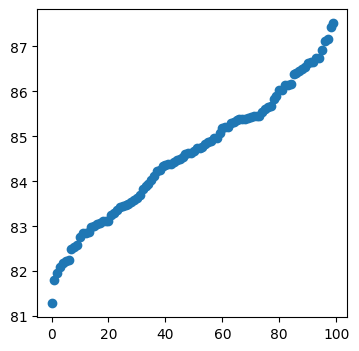

In [35]:
plt.figure(figsize=(4,4))

plt.scatter(range(N),sorted(phase_arrivals))

plt.show()

Now we can write an stram file consisting the N shifted waveforms, as the shift can be as large as 5s, we can do the following:

1. for each location, we change the event starttime by the diff value. The symbol is the same.
2. We do cutting around ref_start + 30 => ref_start + 90.
3. At the same time, write all the info to seprate files.

In [42]:
ref_trace=data.waveforms["1_52200.FONI"].raw_recording[2].copy()
s,e=ref_trace.stats.starttime+30,ref_trace.stats.starttime+90

st=Stream()
for i in range(N):
    cur=ref_trace.copy()
    cur.stats.starttime+=phase_arrivals[i]-ref_t
    tr=cur.slice(s,e)
    tr.normalize()
    st+=tr

Now we can plot stream, firstly use the origional order, then sort them based on arrival times.

In [45]:
def plot(st):
    plt.figure(figsize=(12,8))
    for i in range(N):
        tr=st[i]
        x=np.linspace(-20,40,len(tr.data))
        y=tr.data*0.5+i
        plt.plot(x,y,color="k")
    plt.show()

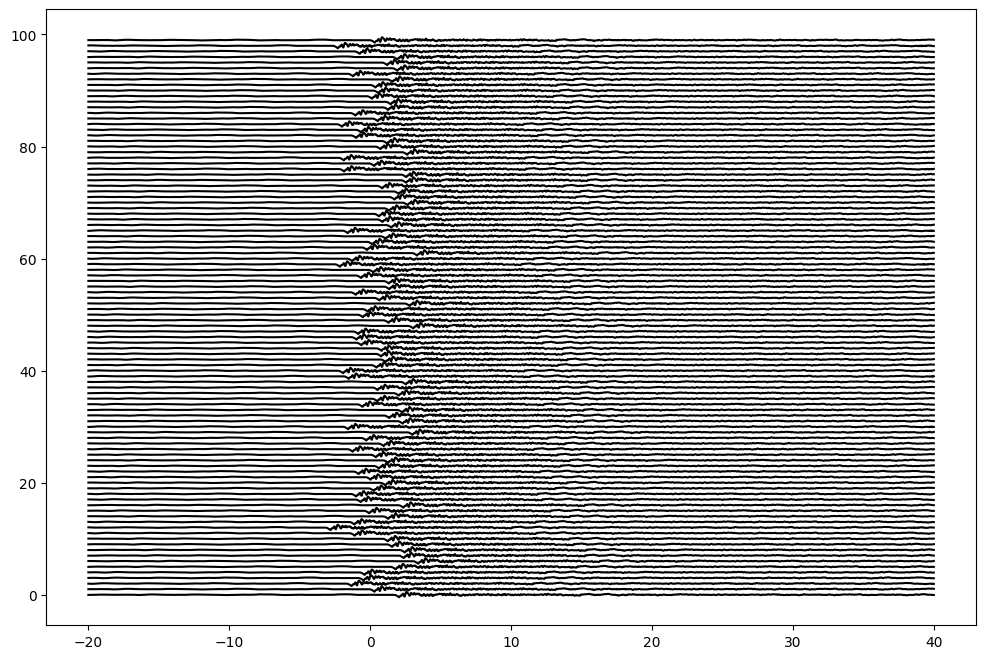

In [46]:
plot(st)

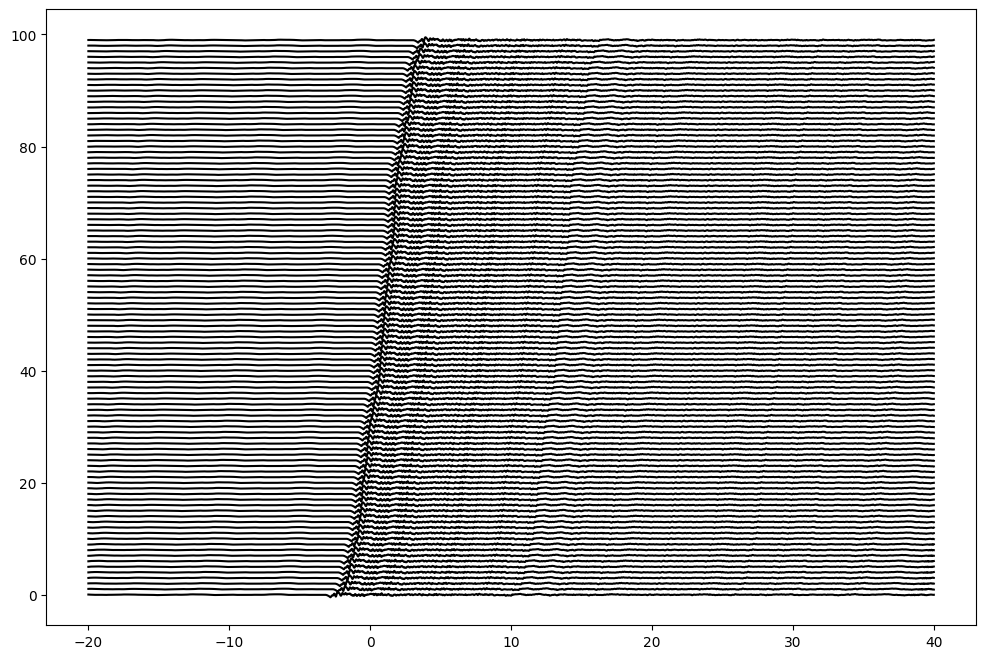

In [47]:
# now sort based on phase arrival time
status=[]
for i in range(N):
    status.append((phase_arrivals[i],st[i]))
status.sort()

plot([item[1] for item in status])

In [49]:
# Now we should save everything

tosave={
    "st":st,
    "lons":lons,
    "lats":lats,
    "deps":deps,
    "phase_arrivals":phase_arrivals
}

with open('./data/sync1.pkl', 'wb') as handle:
    pickle.dump(tosave, handle, protocol=pickle.HIGHEST_PROTOCOL)